<a href="https://colab.research.google.com/github/wlsisl/ESAA_/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8ch7_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH7 앙상블 학습과 랜덤 포레스트

앙상블 : 일련의 예측기

앙상블 학습 : 일련의 예측기로부터 예측을 수집하여 학습하는 것

랜덤포레스트 : 결정트리의 앙상블

## 7.1 투표 기반 분류기

더 좋은 분류기를 만드는 방법  (직접 투표 분류기법) : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것

* 앙상블 기법은 예측기가 가능한 서로 독리적일 때 최고의 성능 발휘
* 다양한 분류기를 얻는 방법은 다른 알고리즘으로 학습시키는 것이다. 
* 같은 데이터로 훈련시키기 때문에 분류기들이 같은 종류의 오차를 만들기 쉬워서, 정확도가 낮아짐 따라서 다른 알고리즘으로 한다면 다른 종류의 오차를 만들 가능성이 높아짐


In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y=make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [2]:
#사이킷런의 투표 기반 분류기를 만들고 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



In [3]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),('svc',svm_clf)],voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9
RandomForestClassifier 1.0
SVC 0.95
VotingClassifier 0.95


-> 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

[간접 투표]

* 모든 분류기가 클래스의 확률을 예측할 수 있으면(predict_proba()메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다. 
* 직접 투표보다 성능이 높다. 
* 이용하기위해서 voting="hard"를 voting="soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨.
* SVC는 기본값에서 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야함.


## 7.2 배깅과 페이스팅

배깅 : 훈련세트에서 중복을 허용하여 샘프링하는 방식

페이스팅 : 중복을 허용하지 않고 샘플링 하는 방식

-> 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
수집 함수는 전형적으로 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산한다.

### 7.2.1 사이킷런의 배깅과 페이스팅

배깅과 페이스팅 API : BaggingClassifier

* BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 직접 투표 대신 자동으로 간접 투표 방식을 사용함.

In [5]:
#결정 트리 분류기 500개의 앙상블을 훈련시키는 코드
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500, max_samples=50, bootstrap = True, n_jobs = -1) #n_jobs = cpu코어 수 지정, -1은 가용한 모든 코어를 사용한다.
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

-> 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

### 7.2.2 oob 평가

**oob샘플** : 예측기에 훈련 샘플의 63%정도만 샘플링이 되고 선택되지 않은 훈련 샘플의 나머지 37%를 oob샘플이라고 한다.

* 예측기가 훈련되는 동안에는 oob샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다. 
앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻는다.

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500, bootstrap=True, n_jobs=-1, oob_score =True) # oob_score =True는 훈련 끝나면 자동으로 oob평가를 수행해줌

bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.9125

In [7]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

두 정확도가 비슷하다.

\
 결정함수는 각 훈련 샘플의 클래스 확률을 반환한다. 

In [8]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.79096045, 0.20903955],
       [0.37572254, 0.62427746],
       [0.00520833, 0.99479167],
       [0.00584795, 0.99415205],
       [0.5625    , 0.4375    ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.54216867, 0.45783133],
       [0.        , 1.        ],
       [0.64      , 0.36      ],
       [0.9127907 , 0.0872093 ],
       [0.69832402, 0.30167598],
       [0.84530387, 0.15469613],
       [0.        , 1.        ],
       [0.9516129 , 0.0483871 ],
       [0.9132948 , 0.0867052 ],
       [0.        , 1.        ],
       [0.97826087, 0.02173913],
       [0.16393443, 0.83606557],
       [0.98941799, 0.01058201],
       [0.07179487, 0.92820513],
       [0.44864865, 0.55135135],
       [0.        , 1.        ],
       [0.03278689, 0.96721311],
       [0.        , 1.        ],
       [0.86413043, 0.13586957],
       [0.92391304, 0.07608696],
       [0.        , 1.        ],
       [0.96531792, 0.03468208],
       [0.

oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 68.25%로 추정하고 있다.


---

##7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier에 있는 **특성 샘플링**

 max_features, boostrap_features 

 -> 이미지와 같은 고차원 데이터셋 다룰 떄 유용함. 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.


랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것

랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것



---

##7.4 랜덤 포레스트


> 랜덤 포레스트는 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블

* max_samples를 훈련 세트의 크기로 지정


In [9]:
#500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 cpu코어에서 훈련시키는 코드

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)

<특징>

트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 **무작위로 선택한 특성 후보 중에서 최적의 특성**을 찾는 식으로 무작위성을 더 주입한다. 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다.

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),n_estimators=500, max_samples=-1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

익스트림 랜덤 트리 : 극단적으로 무작위한 트리의 랜덤 포레스트
* 편향이 늘어나지만 분산을 낮춤. 
* 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 시간이 많이 소요되는데, 그래서 엑스트라 트리는 훨씬 빠름
* ExtraTreesClassifier을 사용함

### 7.4.2 특성 중요도

* 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉬움.
* 사이킷런은 훈련이 끝난 뒤 자동으로 이점수를 계산함. 
* feature_importances_변수에 저장됨

In [12]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.09929004916395391
sepal width (cm) 0.023585507647813166
petal length (cm) 0.4661977401824962
petal width (cm) 0.41092670300573664


## 7.5 부스팅

부스팅 : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

### 7.5.1 에이다 부스트

이전 예측기를 보완해가면서 일련의 예측기를 학습시키는 것이 부스팅 방법의 아이디어이다.

그 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다. 




In [13]:
#200개의 얕은 결정트리 기반으로 하는 에이다 부스트 분류기 훈련
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate = 0.5) 
 #(max_depth=1) : 결정노드 하나와 리프노드 두개로 이루어진 트리, AdaBoostClassifier의 기본 추정기임
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

> 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다. 

! 에이다 부스트와 다른 점

반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여오차**에 새로운 예측기를 학습시킨다.

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

-> 첫번째 예측기에서 생긴 잔여오차에 두번째 회귀 훈련시키자.

In [15]:
y2= y- tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [16]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

-> 세개의 트리를 포함하는 앙상블 모델이 생겼다. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 된다.

In [17]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2,  tree_reg3))

NameError: ignored

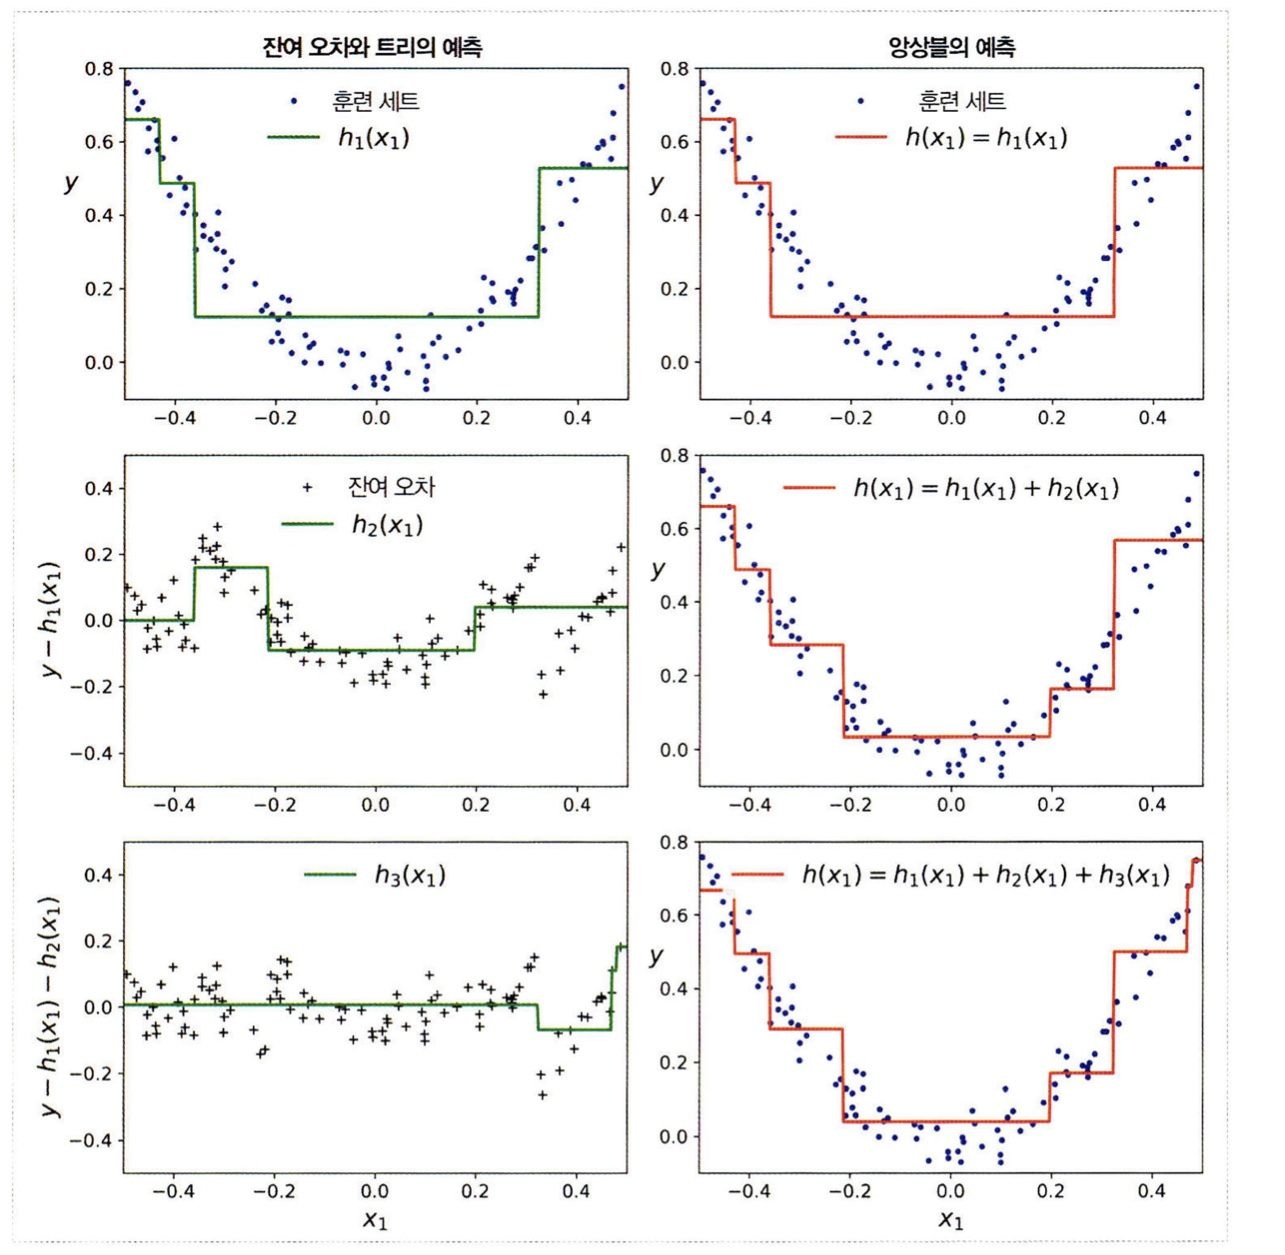왼쪽 열은 이 세 트리의 예측이고 오른쪽 열은 앙상블의 예측

1번째 행 : 앙상블에 트리 하나만 있어서 첫 번째 트리의 예측과 같음

2번째 행 : 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습됨.

(오른쪽 앙상블 ㅇ예측이 두 개의 트리 예측의 합과 같음)

-> 앙상블 추가될수록 앙상블의 예측이 점차 좋아짐.

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt= GradientBoostingRegressor(max_depth = 2, n_estimators=3, learning_rate = 1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

learning_rate 매개변수 : 각 트리의 기여 정도를 조절

* 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아진다.
-> **축소** 규제 방법

[작은 학습률로 훈련시킨 두 GBRT 앙상블]

왼쪽 : 훈련 세트를 학습하기에는 트리가 충분하지 않음

오른쪽 : 트리가 넘 많아 훈련세트에 과대적합됨.   -> 조기종료 기법을 사용해보자.

**1. 최적의 트리 수 찾기**

In [21]:
#staged_predict()메서드를 사용하여 훈련 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환
#최적의 트리 수 찾기 위해 가가 훈련 단계에서 검증 오차 측정
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors= [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators=np.argmin(errors)+1

#마지막 최적의 트리수를 사용해 새로운 GBRT앙상블 훈련
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=115)

**2. 실제 훈련 중지 방법으로 조기종료 구현**

warm_start=True 로 설정하면 사이킷런 fit메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌. 

In [25]:
#연속해서 다섯 번의 반복동안 검증 오차가 향상되지 않으면 훈련을 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error  =mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else: 
    error_going_up +=1
    if error_going_up ==5:
      break

> 확률적 그레이디언트 부스팅 : 트리 훈련시 훈련 샘플의 비율을 지정할 수 있는데, 편향이 높아지는 대시 ㄴ분산이 낮아지고 훈련 속도를 높인다.

In [23]:
#Xgboost

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [28]:
xgb_reg.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.38498
[1]	validation_0-rmse:0.31456
[2]	validation_0-rmse:0.26535
[3]	validation_0-rmse:0.23751
[4]	validation_0-rmse:0.22176
[5]	validation_0-rmse:0.22022
[6]	validation_0-rmse:0.22175


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


## 7.6 스태킹

" 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까?" 

\

1. 훈련세트 두 개의 서브셋으로 나누기
2. 첫번째 레이어의 예측기를 사용해 두번째 세트에 대한 예측을 만든다.
-> 사이킷런은 스태킹 직접 지원 x